# 📄 Compute the kernel regression errors for all variables (**Figure 8**)

***

In [1]:
%run -i imports.py
%matplotlib inline

In [2]:
n_components = 3
sample_percentage = 100

In [3]:
data_tag = 'clustered-flamelet-CO-H2-10-1'
# data_tag = 'clustered-flamelet-H2'
# data_tag = 'clustered-flamelet-C2H4'
%run -i load-SLFM-data.py

Removing N2.

The data set has 14550 observations.

Using: T, H2, O2, OH, H2O, CO, CO2 as target variables.


In [4]:
# Set the kernel regression parameters here:
train_perc = 80
test_perc = 20

if data_tag == 'clustered-flamelet-H2':
    n_neighbors = 250
    n_neighbors_subset = 250
if data_tag == 'clustered-flamelet-CO-H2-10-1':
    n_neighbors = 50
    n_neighbors_subset = 50
if data_tag == 'clustered-flamelet-C2H4':
    n_neighbors = 50
    n_neighbors_subset = 50

In [5]:
if data_tag == 'clustered-flamelet-H2':

    regressed_variables_names = ['$S_{Z,1}$',
     '$S_{Z,2}$',
     '$S_{Z,3}$',
     '$T$',
     'H',
     'H$_2$',
     'O',
     'OH',
     'H$_2$O',
     'O$_2$',
     'HO$_2$',
     'H$_2$O$_2$']

if data_tag == 'clustered-flamelet-CO-H2-10-1':
    
    regressed_variables_names = ['$S_{Z,1}$',
     '$S_{Z,2}$',
     '$S_{Z,3}$',
     '$T$',
     'H$_2$',
     'O$_2$',
     'O',
     'OH',
     'H$_2$O',
     'H',
     'HO$_2$',
     'CO',
     'CO$_2$',
     'HCO']
    
if data_tag == 'clustered-flamelet-C2H4':
    
    regressed_variables_names = ['$S_{Z,1}$',
     '$S_{Z,2}$',
     '$S_{Z,3}$',
     '$T$',
     'H$_2$',
     'H',
     'O',
     'O$_2$',
     'OH',
     'H$_2$O',
     'HO$_2$',
     'H$_2$O$_2$',
     'CH',
     'CH$_2$',
     'CH$_2$*',
     'CH$_3$',
     'CH$_4$',
     'CO',
     'CO$_2$',
     'HCO',
     'CH$_2$O',
     'CH$_3$O',
     'C$_2$H$_2$',
     'H$_2$CC',
     'C$_2$H$_3$',
     'C$_2$H$_4$',
     'C$_2$H$_5$',
     'C$_2$H$_6$',
     'HCCO',
     'CH$_2$CO',
     'CH$_2$CHO',
     'CH$_3$CHO',
     'aC$_3$H$_5$',
     'C$_3$H$_6$',
     'nC$_3$H$_7$']

In [6]:
optimizing_higlight = [i for i in range(0,n_components)] + list(np.array(target_variables_indices) + n_components)

***

## Run nonlinear regression on a manifold computed from the full state vector, $\mathbf{X}$

In [7]:
if data_tag == 'clustered-flamelet-H2':
    scaling = 'max'
if data_tag == 'clustered-flamelet-CO-H2-10-1':
    scaling = '-1to1'
if data_tag == 'clustered-flamelet-C2H4':
    scaling = 'range'

In [8]:
total_tic = time.perf_counter()

pca = reduction.PCA(state_space, scaling=scaling, n_components=n_components)
PCs = pca.transform(state_space)
PC_sources = pca.transform(state_space_sources, nocenter=True)

symlog_PC_sources = preprocess.log_transform(PC_sources, method='continuous-symlog', threshold=1.e-4)

OUTPUT = np.hstack((PC_sources, state_space))
(_,n_regressed_variables) = np.shape(OUTPUT)
(PCs_pp, centers_PCs, scales_PCs) = preprocess.center_scale(PCs, '-1to1')

sample_random = preprocess.DataSampler(np.zeros((n_observations,)).astype(int), random_seed=random_seed, verbose=False)
(idx_train, idx_test) = sample_random.random(train_perc)

PCs_pp_train = PCs_pp[idx_train,:]
OUTPUT_train = OUTPUT[idx_train,:]
PCs_pp_test = PCs_pp[idx_test,:]
OUTPUT_test = OUTPUT[idx_test,:]

model = analysis.KReg(PCs_pp_train, OUTPUT_train)

OUTPUT_predicted_test = model.predict(PCs_pp_test, bandwidth='nearest_neighbors_isotropic', n_neighbors=n_neighbors)
OUTPUT_predicted_train = model.predict(PCs_pp_train, bandwidth='nearest_neighbors_isotropic', n_neighbors=n_neighbors)

NRMSE_collected_test = []
for i in range(0, n_regressed_variables):
    NRMSE_test = analysis.normalized_root_mean_squared_error(OUTPUT_test[:,i], OUTPUT_predicted_test[:,i], norm='std')
    NRMSE_collected_test.append(NRMSE_test)

NRMSE_collected_train = []
for i in range(0, n_regressed_variables):
    NRMSE_train = analysis.normalized_root_mean_squared_error(OUTPUT_train[:,i], OUTPUT_predicted_train[:,i], norm='std')
    NRMSE_collected_train.append(NRMSE_train)

total_toc = time.perf_counter()
print(f'\nTotal time: {(total_toc - total_tic)/60:0.1f} minutes.')


Total time: 0.1 minutes.


***

## Run nonlinear regression on a manifold computed from the optimized state vector subset, $\mathbf{X}_S$

#### Hydrogen

In [9]:
if data_tag == 'clustered-flamelet-H2':

    scaling = 'auto'
    selected_variables_list = [6, 3, 0, 1, 2, 4]
    print(state_space_names[selected_variables_list])

#### Syngas

In [10]:
if data_tag == 'clustered-flamelet-CO-H2-10-1':

    scaling = 'range'
    selected_variables_list = [9, 8, 6, 3, 4]
    print(state_space_names[selected_variables_list])

['CO2' 'CO' 'H' 'O' 'OH']


#### Ethylene

In [11]:
if data_tag == 'clustered-flamelet-C2H4':
    
    scaling = 'auto'
    selected_variables_list = [15,6,4,5,16,12,19,22,0,2,26,1]
    print(state_space_names[sorted(selected_variables_list)])

In [12]:
total_tic = time.perf_counter()

subset_pca = reduction.PCA(state_space[:,selected_variables_list], scaling=scaling, n_components=n_components)
subset_PCs = subset_pca.transform(state_space[:,selected_variables_list])
subset_PC_sources = subset_pca.transform(state_space_sources[:,selected_variables_list], nocenter=True)

symlog_subset_PC_sources = preprocess.log_transform(subset_PC_sources, method='continuous-symlog', threshold=1.e-4)

subset_OUTPUT = np.hstack((subset_PC_sources, state_space))
(_,n_regressed_variables) = np.shape(subset_OUTPUT)
(PCs_pp, centers_PCs, scales_PCs) = preprocess.center_scale(subset_PCs, '-1to1')

sample_random = preprocess.DataSampler(np.zeros((n_observations,)).astype(int), random_seed=random_seed, verbose=False)
(idx_train, idx_test) = sample_random.random(train_perc)

PCs_pp_train = PCs_pp[idx_train,:]
subset_OUTPUT_train = subset_OUTPUT[idx_train,:]
PCs_pp_test = PCs_pp[idx_test,:]
subset_OUTPUT_test = subset_OUTPUT[idx_test,:]

model = analysis.KReg(PCs_pp_train, subset_OUTPUT_train)

subset_OUTPUT_predicted_test = model.predict(PCs_pp_test, bandwidth='nearest_neighbors_isotropic', n_neighbors=n_neighbors_subset)
subset_OUTPUT_predicted_train = model.predict(PCs_pp_train, bandwidth='nearest_neighbors_isotropic', n_neighbors=n_neighbors_subset)

subset_NRMSE_collected_test = []
for i in range(0, n_regressed_variables):
    NRMSE_test = analysis.normalized_root_mean_squared_error(subset_OUTPUT_test[:,i], subset_OUTPUT_predicted_test[:,i], norm='std')
    subset_NRMSE_collected_test.append(NRMSE_test)
    
subset_NRMSE_collected_train = []
for i in range(0, n_regressed_variables):
    NRMSE_train = analysis.normalized_root_mean_squared_error(subset_OUTPUT_train[:,i], subset_OUTPUT_predicted_train[:,i], norm='std')
    subset_NRMSE_collected_train.append(NRMSE_train)

total_toc = time.perf_counter()
print(f'\nTotal time: {(total_toc - total_tic)/60:0.1f} minutes.')


Total time: 0.1 minutes.


***

## Compare regression results 

In [13]:
regression_metrics_test = analysis.RegressionAssessment(OUTPUT_test, OUTPUT_predicted_test, variable_names=regressed_variables_names)
subset_regression_metrics_test = analysis.RegressionAssessment(subset_OUTPUT_test, subset_OUTPUT_predicted_test, variable_names=regressed_variables_names)

In [14]:
regression_metrics_test.print_metrics(table_format=['pandas'],
                                   float_format='.5f',
                                   metrics=['NRMSE'])

,NRMSE
"$S_{Z,1}$",0.07720
"$S_{Z,2}$",0.06154
"$S_{Z,3}$",0.07151
$T$,0.03349
H$_2$,0.02462
O$_2$,0.01544
O,0.02378
OH,0.02771
H$_2$O,0.04815
H,0.04144


In [15]:
subset_regression_metrics_test.print_metrics(table_format=['pandas'],
                                   float_format='.5f',
                                   metrics=['NRMSE'],
                                   comparison=regression_metrics_test)

,NRMSE
"$S_{Z,1}$",0.03200
"$S_{Z,2}$",0.05717
"$S_{Z,3}$",0.04615
$T$,0.02313
H$_2$,0.01726
O$_2$,0.01521
O,0.01723
OH,0.03447
H$_2$O,0.03658
H,0.03002


***

## ✏️ Plot NRMSE comparison on test data only

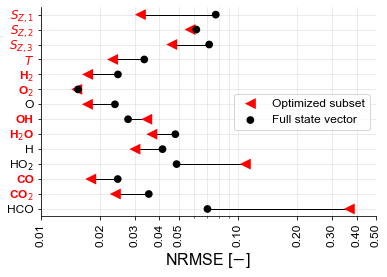

In [16]:
fig = plt.figure(figsize=(6, 0.35*len(state_space_names)))
fig.tight_layout(pad=-30)
spec = fig.add_gridspec(ncols=1, nrows=1)
widths = [1]
heights = [1]
spec = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, height_ratios=heights)

x_range = np.array([i for i in range(0,n_regressed_variables)])

ax = fig.add_subplot(spec[0,0])

plt.scatter(subset_NRMSE_collected_test, x_range, c='r', marker='<', s=120, edgecolor='none', zorder=5, label='Optimized subset')
plt.scatter(NRMSE_collected_test, x_range, c='k', marker='o', s=60, edgecolor='none',  zorder=5, label='Full state vector')

plt.yticks(x_range, regressed_variables_names, fontsize=12)
plt.grid(alpha=0.3, zorder=0)
plt.ylim([-0.5,len(x_range)-0.5])
plt.xlabel('NRMSE [$-$]', fontsize=16)

ax.set_xscale('log')

for i in optimizing_higlight:
    ax.get_yticklabels()[i].set_color('r')
    ax.get_yticklabels()[i].set_fontweight(1000)

if data_tag == 'clustered-flamelet-H2':
    ax.set_xticks([0.07,0.08,0.09,0.1,0.2,0.3,0.4,0.5,0.6])
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    plt.xlim([0.065,0.6])
    lgnd = plt.legend(ncol=1, fontsize=12, markerscale=marker_scale_legend, loc="upper left")
    
if data_tag == 'clustered-flamelet-CO-H2-10-1':
    ax.set_xticks([0.01,0.02,0.03,0.04,0.05,0.1,0.2,0.3,0.4,0.5])
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    plt.xlim([0.01,0.5])
    lgnd = plt.legend(ncol=1, fontsize=12, markerscale=marker_scale_legend, loc="center right")

if data_tag == 'clustered-flamelet-C2H4':
    ax.set_xticks([0.02,0.03,0.04,0.05,0.1,0.2,0.3,0.4,0.5,0.6])
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    plt.xlim([0.025,0.6])
    lgnd = plt.legend(ncol=1, fontsize=12, markerscale=marker_scale_legend, loc="upper left")
    
plt.xticks(fontsize=12, rotation=90)
plt.gca().invert_yaxis()
plt.grid(b=True, which='minor', alpha=0.3, zorder=0)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

for i in range(0, n_regressed_variables):

    x_values = [x_range[i], x_range[i]]
    y_values = [NRMSE_collected_test[i], subset_NRMSE_collected_test[i]]
    plt.plot(y_values, x_values, color='k', ls='-', lw=1, zorder=3)
    
plt.savefig('../figures/Figure-8.png', dpi=200, bbox_inches='tight')

***